In [14]:
import pickle
from langgraph.graph import StateGraph, START, END
from typing import List, Tuple, Dict, Callable, Optional
from langchain_community.vectorstores import FAISS
from langchain_community.retrievers import BM25Retriever
from langchain.retrievers.ensemble import EnsembleRetriever
from langchain_google_genai import GoogleGenerativeAIEmbeddings
import google.generativeai as genai
from langgraph.graph import MessagesState
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_community.utilities import DuckDuckGoSearchAPIWrapper
import logging

In [15]:
# Grader 프롬프트
GRADE_PROMPT = """
아래는 사용자의 질문과 검색된 문서(또는 context)입니다.

[질문]
{question}

[검색된 문서/컨텍스트]
{context}

이 context만으로 사용자의 질문에 충분히 답변할 수 있으면 'yes', 부족하면 'no'로만 답변하세요.
"""

In [16]:
# Gemini2.0-flash LLM을 이용해 context가 답변에 충분한지 평가하는 함수
# (VectorDB에서 Retrieve된 문서가 user query에 대해 답변하기에 적절/충분한지 판정)
def context_sufficient_llm(question: str, context: str) -> bool:
    """
    Gemini2.0-flash grader_model을 사용하여, 주어진 context(문서 집합)가
    user query(질문)에 대해 답변하기에 충분한지 평가합니다.
    - 충분하면 'yes', 부족하면 'no'를 반환하도록 프롬프트 설계
    - 'yes'로 시작하면 sufficient, 아니면 insufficient으로 간주
    """
    grader_model = genai.GenerativeModel('models/gemini-2.0-flash')
    prompt = GRADE_PROMPT.format(question=question, context=context)
    # logger.info(f"[Grader] 질문: {question}\n컨텍스트 길이: {len(context)}")
    response = grader_model.generate_content(prompt)
    answer = response.text.strip().lower()
    # logger.info(f"[Grader] LLM 판정 결과: {answer}")
    return answer.startswith("yes")


In [17]:
# 앙상블 리트리버 생성 함수 (유틸)
def build_ensemble_retriever(faiss_vectorstore, bm25_retriever):
    faiss_retriever = faiss_vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 5})
    bm25_retriever.k = 5
    return EnsembleRetriever(
        retrievers=[faiss_retriever, bm25_retriever],
        weights=[0.5, 0.5]
    )

def create_and_save_vectorstores(documents, faiss_path, bm25_path, embedding_model=None):
    # 1. 문서 chunking
    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=200,
        chunk_overlap=50,
        model_name="gpt-4"
    )
    chunked_documents = []
    for doc in documents:
        # doc는 langchain_core.documents.Document 객체라고 가정
        chunked = text_splitter.split_documents([doc])
        chunked_documents.extend(chunked)
    # 2. 벡터스토어 생성
    faiss_vectorstore = FAISS.from_documents(
        documents=chunked_documents,
        embedding=embedding_model
    )
    faiss_vectorstore.save_local(faiss_path)
    bm25_retriever = BM25Retriever.from_documents(chunked_documents)
    with open(bm25_path, "wb") as f:
        pickle.dump(bm25_retriever, f)
    return faiss_vectorstore, bm25_retriever

In [18]:
def deduplicate_documents(docs):
    # page_content 기준으로 중복 제거
    seen = set()
    unique_docs = []
    for doc in docs:
        key = getattr(doc, "page_content", str(doc))
        if key not in seen:
            seen.add(key)
            unique_docs.append(doc)
    return unique_docs

In [19]:
def get_user_question_from_state(state):
    for msg in reversed(state["messages"]):
        # MessagesState의 메시지는 HumanMessage/AIMessage 등 객체임
        if getattr(msg, "type", None) == "human":
            return msg.content
    raise ValueError("user 메시지가 없습니다.")

def article_search_node(state, ensemble_retriever, article_id=None):
    print('단일 기사 검색 노드')
    user_question = get_user_question_from_state(state)
    filter_dict = {"article_id": article_id} if article_id else None
    context = ensemble_retriever.invoke(user_question, filter=filter_dict)
    print(f"[article_search_node] context 개수: {len(context)}")
    for i, doc in enumerate(context):
        print(f"  [{i}] {getattr(doc, 'page_content', str(doc))[:100]}")
    state = dict(state)
    # 누적 및 중복 제거
    prev_context = state.get("context", [])
    new_context = deduplicate_documents(prev_context + context)
    state["context"] = new_context
    state["step"] = "article_search"
    state.setdefault("trace", []).append(("article_search", [doc.page_content[:100] for doc in context]))
    return state

def all_search_node(state, ensemble_retriever):
    print('전체 기사 검색 노드')
    user_question = get_user_question_from_state(state)
    context = ensemble_retriever.invoke(user_question)
    print(f"[article_search_node] context 개수: {len(context)}")
    for i, doc in enumerate(context):
        print(f"  [{i}] {getattr(doc, 'page_content', str(doc))[:100]}")
    state = dict(state)
    prev_context = state.get("context", [])
    new_context = deduplicate_documents(prev_context + context)
    state["context"] = new_context
    state["step"] = "all_search"
    state.setdefault("trace", []).append(("all_search", [doc.page_content[:100] for doc in context]))
    return state

def web_search_node(state, web_search_func):
    print('인터넷 검색 노드')
    user_question = get_user_question_from_state(state)
    context = web_search_func(user_question)
    print(f"[article_search_node] context 개수: {len(context)}")
    for i, doc in enumerate(context):
        print(f"  [{i}] {getattr(doc, 'page_content', str(doc))[:100]}")
    state = dict(state)
    prev_context = state.get("context", [])
    # web_search_func가 str 리스트 반환 시, 문서 객체로 변환 필요시 변환
    new_context = deduplicate_documents(prev_context + context)
    state["context"] = new_context
    state["step"] = "web_search"
    state.setdefault("trace", []).append(("web_search", context))
    return state

In [20]:
def context_sufficiency_condition(state) -> str:
    print('LLM 문맥 평가 분기')
    user_question = get_user_question_from_state(state)
    context = state.get("context", [])
    if context and hasattr(context[0], "page_content"):
        context_text = "\n\n".join([doc.page_content for doc in context])
    else:
        context_text = "\n\n".join([str(c) for c in context])
    if context and context_sufficient_llm(user_question, context_text):
        return "sufficient"
    else:
        return "insufficient"

In [21]:
def build_prompt(context: List, user_question: str, chat_history: List[Tuple[str, str]]) -> str:
    context_text = "\n\n".join([doc.page_content for doc in context])
    history_text = "\n".join([f"Q: {q}\nA: {a}" for q, a in chat_history])
    prompt = f"""
[대화 내역]
{history_text}

[참고 기사/문서 내용]
{context_text}

[질문]
{user_question}

위 참고 내용과 대화 내역을 바탕으로, 사용자의 질문에 대해 정확하고 친절하게 답변해 주세요.
"""
    return prompt

In [22]:
def generate_with_gemini_node(state, chat_history_getter=None):
    print("state keys in [generate_with_gemini_node]:", list(state.keys()))
    user_question = get_user_question_from_state(state)
    context = state.get("context", [])
    # context_text만 사용
    if context and hasattr(context[0], "page_content"):
        context_text = "\n\n".join([doc.page_content for doc in context])
    else:
        context_text = "\n\n".join([str(c) for c in context])
    print(f"[generate_with_gemini_node] context_text 길이: {len(context_text)}")
    print(f"[generate_with_gemini_node] context_text 미리보기: {context_text[:200]}")
    print(f"[generate_with_gemini_node] user_question: {user_question}")
    prompt = f"""
[참고 기사/문서 내용]
{context_text}

[질문]
{user_question}

위 참고 내용만 바탕으로, 사용자의 질문에 대해 정확하고 친절하게 답변해 주세요.
"""
    model = genai.GenerativeModel('models/gemini-2.0-flash')
    response = model.generate_content(prompt)
    state = dict(state)
    state["answer"] = response.text
    # messages에 답변 누적(선택)
    state.setdefault("messages", []).append({"role": "assistant", "content": response.text})
    return state

In [23]:
# 그래프 빌더 함수
def build_adaptive_rag_graph(ensemble_retriever, web_search_func, article_id=None):
    workflow = StateGraph(MessagesState)
    # 노드 등록
    workflow.add_node("article_search", lambda state: article_search_node(state, ensemble_retriever, article_id))
    workflow.add_node("all_search", lambda state: all_search_node(state, ensemble_retriever))
    workflow.add_node("web_search", lambda state: web_search_node(state, web_search_func))
    workflow.add_node("generate_answer", generate_with_gemini_node)
    # 엣지 연결
    workflow.add_edge(START, "article_search")
    workflow.add_conditional_edges(
        "article_search",
        context_sufficiency_condition,
        {"sufficient": "generate_answer", "insufficient": "all_search"}
    )
    workflow.add_conditional_edges(
        "all_search",
        context_sufficiency_condition,
        {"sufficient": "generate_answer", "insufficient": "web_search"}
    )
    workflow.add_edge("web_search", "generate_answer")
    workflow.add_edge("generate_answer", END)
    # 컴파일
    return workflow.compile()

In [24]:
# 1. 임베딩 모델
embeddings = GoogleGenerativeAIEmbeddings(
    model="models/embedding-001",
    task_type="retrieval_document"
)

# 2. 문서 예시 (실제 Document 객체로 대체 가능)
from langchain_core.documents import Document
documents = [
    Document(page_content="""
SNS 기사보내기
SNS 기사보내기페이스북(으)로 기사보내기 트위터(으)로 기사보내기 카카오톡(으)로 기사보내기 네이버블로그(으)로 기사보내기
다음 기사
스크롤 이동 상태바
현재위치
 홈산업산업일반
바로가기 본문 글씨 줄이기 본문 글씨 키우기
"기존 검색 대신 AI 검색 노출에 최적화"....어도비, 'GEO' 도구 출시
기자명 임대준 기자   입력 2025.06.17 19:05  수정 2025.06.18 05:57  댓글 0  좋아요 1
 
SNS 기사보내기
SNS 기사보내기페이스북(으)로 기사보내기 트위터(으)로 기사보내기 카카오톡(으)로 기사보내기 네이버블로그(으)로 기사보내기 AI타임스 유튜브
(사진=어도비)
(사진=어도비)
어도비가 대형언어모델(LLM)에 브랜드가 쉽게 노출될 수 있도록 돕는 인공지능(AI) 도구를 선보였다. 이는 AI 검색이 기존 검색을 점차 대체한다는 분위기에 맞춰 등장한 '생성 엔진 최적화(GEO)' 기술이다.

어도비는 16일(현지시간) 프랑스에서 열린 국제 광고제 '칸 라이언즈 페스티벌'에서 '어도비 LLM 옵티마이저(Optimizer)'를 선보였다. 이는 기업의 콘텐츠가 AI 검색에 더 잘 노출될 수 있도록 지원하는 새로운 도구다.

어도비는 "현재 고객들은 기존 검색 엔진이 아닌 AI 비서로부터 브랜드를 찾는 경우가 점점 더 많아지고 있다"라며 "챗GPT나 클로드, 퍼플렉시티 같은 생성 AI 플랫폼이 정보 및 의사 결정을 위한 필수 도구로 자리 잡으면서, LLM이 브랜드 발견의 새로운 관문으로 부상하고 있다"라고 소개했다.

또 베인앤컴퍼니에 따르면 소비자의 80%가 검색의 최소 40%를 AI가 작성한 요약에 의존하며, 가트너는 소비자들이 기존 검색에서 벗어나면서 2028년까지 브랜드의 유기적 트래픽이 50% 이상 감소할 것으로 전망한다고 소개했다.

LLM 옵티마이저는 기업이 이런 변화를 활용할 수 있도록 지원하는 GEO 기술이라고 소개했다. 이는 3가지 핵심 부분으로 구성돼 있다.

우선, '자동 식별(Auto Identify)' 시스템은 주요 AI 모델이 브랜드 콘텐츠를 어떻게 사용하는지 감지한다. 콘텐츠의 '지문'을 추적해 관련 쿼리에 대한 응답에 콘텐츠가 표시되는지와 표시 방식을 파악한다.

이어 '자동 제안(Auto Suggest)' 기능은 어도비의 자체 AI 모델을 활용해 기술 인프라와 콘텐츠 전반에 걸쳐 GEO에 맞춘 개선 사항을 추천한다. 여기에는 메타데이터 오류 수정부터 FAQ 콘텐츠의 개선까지 다양한 방안이 포함된다.

이어 '자동 최적화(Auto Optimize)'로 수정 사항을 적용한다. 이때 생성 AI 기능을 활용, 기업은 개발팀 지원 없이도 자연어로 수정 사항을 적용할 수 있다는 설명이다.

자동 식별 기능을 통해 파악된 콘텐츠 노출 상황 (사진=어도비)
자동 식별 기능을 통해 파악된 콘텐츠 노출 상황 (사진=어도비)
즉, 회사 콘텐츠가 생성 AI 챗봇에 노출되는지, 또 이를 위해 무엇을 해야 하는지를 알려주고 조치한다는 내용이다.

이처럼 최근에는 기존의 검색 엔진 최적화(SEO)를 넘어 AI 챗봇에 더 잘 노출되기 위한 움직임이 가속화되고 있다. 챗봇의 답변에 포함되는 것은 매출의 상승과 콘텐츠의 권위를 높일 수 있기 때문이다.

이 가운데 기술 거대 기업인 어도비가 직접 나섰다는 것은 이 시장의 성장 가능성이 대단하다는 것을 보여주는 것이다.

로니 스타크 어도비 전략 및 제품 담당 부사장은 "생성 AI 인터페이스는 고객이 제품을 발견하고, 참여하고, 구매 결정을 내리는 데 필수적인 도구로 자리 잡고 있다"라며 "우리는 새로운 환경에서 기업이 성공을 거둘 수 있도록 지원할 것"이라고 말했다.

임대준 기자 ydj@aitimes.com

1

키워드 관련기사
"AI 에이전트로 인해 인터넷은 '머신 네이티브'로 변화할 것"
AI 검색 광고 시장, 5년 내 26배로 증가...비중은 14%에 그쳐
[5월2주] '웰컴, 크롤러'...웹사이트가 인간 아닌, AI 위한 데이터 소스로 변한다는 증거
Copyright © '인공지능 전문미디어' AI타임스 (http://www.aitimes.com)
무단전재 및 재배포 금지

기사제보 및 보도자료 news@aitimes.com
키워드Tags #인공지능 #AI #AI 검색 #어도비 #GEO #SEO
 
임대준 기자
ydj@aitimes.com
 다른기사 보기
기사 댓글 0
""", metadata={"article_id": "A1"}),
    Document(page_content="""
상단영역
2025년 06월 19일 (목)
로그인회원가입

검색
검색어를 입력하세요
검색
전체메뉴 버튼
전체기사
 
뉴스 브리핑
 
Feature
 
인터뷰
 
Future Energy
 
AI WEBTOON
뉴스레터 신청
AI타임스 메뉴닫기
전체기사
뉴스 브리핑
Feature
인터뷰
Future Energy
Art & Living
Global
메타버스
instagram naverpost twitter 카카오톡 채널 youtube
로그인
 매체소개 기사제보
본문영역


이전 기사
AI타임스
아마존 "AI 도입으로 인해 몇년 내 사무직 줄어들 것"
SNS 기사보내기
SNS 기사보내기페이스북(으)로 기사보내기 트위터(으)로 기사보내기 카카오톡(으)로 기사보내기 네이버블로그(으)로 기사보내기
다음 기사
스크롤 이동 상태바
현재위치
 홈산업산업일반
바로가기 본문 글씨 줄이기 본문 글씨 키우기
아마존 "AI 도입으로 인해 몇년 내 사무직 줄어들 것"
기자명 박찬 기자   입력 2025.06.18 18:05  수정 2025.06.19 08:07  댓글 0  좋아요 0
 
SNS 기사보내기
SNS 기사보내기페이스북(으)로 기사보내기 트위터(으)로 기사보내기 카카오톡(으)로 기사보내기 네이버블로그(으)로 기사보내기 AI타임스 유튜브
(사진=셔터스톡)
(사진=셔터스톡)
아마존이 생성 인공지능(AI)과 에이전트의 전면 도입으로 인해 몇년 내 전체 사무직 인력이 줄어들 것이라고 예고했다.

앤디 재시 아마존 CEO는 17일(현지시간) 직원들에게 보낸 메일과 공식 뉴스를 통해 “생성 AI와 에이전트를 더 많이 도입하면서 업무 방식이 바뀔 것”이라며 “현재 사람이 수행 중인 일부 업무에는 더 적은 인력이 필요해지고, 대신 새로운 유형의 일자리에 더 많은 사람이 필요하게 될 것”이라고 밝혔다.

이어 “장기적으로 어떻게 균형이 맞춰질지는 예측하기 어렵지만, 몇년 안에 AI의 광범위한 도입을 통한 효율성 향상으로 인해 전체 사무직 인력이 감소할 것으로 예상한다”라고 설명했다.

또 직원들에게 “AI 도구를 학습하고, 이를 실험해 보며 더 작고 유연한 팀으로 더 많은 성과를 내는 방법을 익혀야 한다”라고 강조했다.

이번 발언은 아마존이 지난 2022년 이후 2만7000명 이상을 감원한 가운데 나온 것이다. 아마존은 올해에도 인력 구조조정을 이어가며, 1월 북미 리테일 부문에서 약 200명, 5월 디바이스 및 서비스 부문에서 추가로 약 100명을 감원한 바 있다.

아마존은 2025년 3월 말 기준 전 세계적으로 정규직 및 시간제 포함 약 156만명의 직원을 보유하고 있으며, 이 외에도 물류창고 운영을 위한 임시직 및 계약직 인력도 활용하고 있다.

이미 물류 네트워크 내 재고 배치, 수요 예측, 창고 로봇 운영 최적화 등 다양한 내부 운영에 생성 AI를 광범위하게 적용하고 있다.

길 루리아 D.A. 데이비드슨 애널리스트는 “아마존은 현재 많은 기술 기업이 강조하는 공통적인 메시지를 전달하고 있다”라며 “AI가 생산성을 빠르게 높이며 채용이 갈수록 줄어든다는 것”이라고 평했다. 특히 “현재 AI로 가장 크게 변화하고 있는 분야는 소프트웨어 개발이며, 이 영역에서 채용 둔화가 두드러진다”라고 덧붙였다.

이는 다른 빅테크도 마찬가지다. 마이크로소프트는 최근 6000명을 감원했으며, 그중 40%는 코더인 것으로 알려졌다. 구글도 최근 1년간 수백명을 감원했으며, 현재 검색 등 주요 분야에서 퇴직 신청을 받고 있다. 여기에는 AI의 인력 대체뿐만 아니라, 데이터센터 등 AI 인프라 구축에 들어가는 엄청난 비용을 확보하려는 의도가 있다. 

한편, 재시 CEO의 발표 직후 내부 직원들의 반발이 거세게 일고 있다.

내부 슬랙(Slack) 메시지에는 그의 발언에 강하게 반발하며 리더십과 AI 중심 경영 기조를 비판하는 내용이 이어지고 있다.

일부 직원들은 AI 의존도가 지나치게 높아질 경우 발생할 수 있는 위험을 경고했다. 또 다른 직원들은 "경영진도 감원 대상에 포함돼야 한다"라고 목소리를 높였다.

박찬 기자 cpark@aitimes.com

0

키워드 관련기사
구글, AI 투자 위해 인원 감축..."검색·광고 팀 포함"
아마존, 인간 대체할 '택배용' 휴머노이드 로봇 테스트
MS, AI 투자 압박으로 인력 3% 해고
Copyright © '인공지능 전문미디어' AI타임스 (http://www.aitimes.com)
무단전재 및 재배포 금지

기사제보 및 보도자료 news@aitimes.com
키워드Tags #아마존 #앤디 재시 #일자리 #감원 #구조조정 #직무 재편성 #인력 감축 #생성 AI #에이전트 #인공지능 #AI
 
박찬 기자
cpark@aitimes.com
 다른기사 보기
기사 댓글 0
""", metadata={"article_id": "A2"}),
]

# 3. 벡터스토어 파일 경로
faiss_path = r"C:\Users\LeeSeungYong\myproject\ai-agent\ai-news-bot\src\vectorstore"
bm25_path = r"C:\Users\LeeSeungYong\myproject\ai-agent\ai-news-bot\src\vectorstore\bm25_all.pkl"

# 4. 벡터스토어/리트리버 생성
faiss_vectorstore, bm25_retriever = create_and_save_vectorstores(
    documents=documents,
    faiss_path=faiss_path,
    bm25_path=bm25_path,
    embedding_model=embeddings
)

ensemble_retriever = build_ensemble_retriever(
    faiss_vectorstore=faiss_vectorstore,
    bm25_retriever=bm25_retriever
)

def web_search_func(query):
    search = DuckDuckGoSearchAPIWrapper()
    results = search.results(query=query, max_results=5)
    print(f"[web_search_func] 검색 결과 개수: {len(results)}")
    for i, item in enumerate(results):
        print(f"  [{i}] {item['title']} - {item.get('snippet','')}")
    if not results:
        return [f"검색 결과 없음: {query}"]
    return [f"{item['title']} - {item.get('snippet','')}" for item in results]

# 6. 그래프 생성
graph = build_adaptive_rag_graph(
    ensemble_retriever=ensemble_retriever,
    web_search_func=web_search_func
)

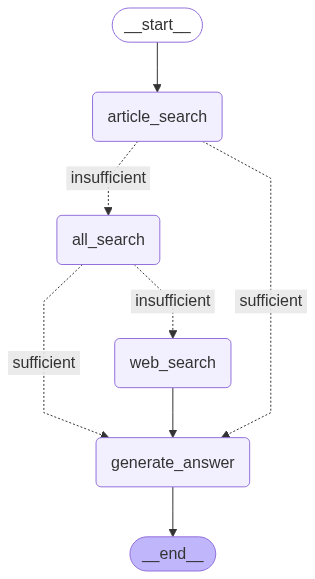

In [25]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
from langchain_core.messages import convert_to_messages

user_question = "빅테크들이 ai 기술로 해고한 사례가 있으면 설명해줘."
state = {
    "messages": convert_to_messages([
        {"role": "user", "content": user_question}
    ]),
    "context": [],
    "trace": []
}

for chunk in graph.stream(state):
    for node, update in chunk.items():
        print(f"[노드: {node}] 결과: {update.get('answer', update.get('context', ''))}")

단일 기사 검색 노드
[article_search_node] context 개수: 9
  [0] 기사제보 및 보도자료 news@aitimes.com
키워드Tags #아마존 #앤디 재시 #일자리 #감원 #구조조정 #직무 재편성 #인력 감축 #생성 AI #에이전트 #인공지능 #A
  [1] 자동 식별 기능을 통해 파악된 콘텐츠 노출 상황 (사진=어도비)
자동 식별 기능을 통해 파악된 콘텐츠 노출 상황 (사진=어도비)
즉, 회사 콘텐츠가 생성 AI 챗봇에 노출되는지, 
  [2] 현재위치
 홈산업산업일반
바로가기 본문 글씨 줄이기 본문 글씨 키우기
아마존 "AI 도입으로 인해 몇년 내 사무직 줄어들 것"
기자명 박찬 기자   입력 2025.06.18 18:
  [3] 박찬 기자 cpark@aitimes.com

0

키워드 관련기사
구글, AI 투자 위해 인원 감축..."검색·광고 팀 포함"
아마존, 인간 대체할 '택배용' 휴머노이드 로봇 테스
  [4] 이전 기사
AI타임스
아마존 "AI 도입으로 인해 몇년 내 사무직 줄어들 것"
SNS 기사보내기
SNS 기사보내기페이스북(으)로 기사보내기 트위터(으)로 기사보내기 카카오톡(으)로
  [5] 한편, 재시 CEO의 발표 직후 내부 직원들의 반발이 거세게 일고 있다.

내부 슬랙(Slack) 메시지에는 그의 발언에 강하게 반발하며 리더십과 AI 중심 경영 기조를 비판하는 
  [6] 이어 “장기적으로 어떻게 균형이 맞춰질지는 예측하기 어렵지만, 몇년 안에 AI의 광범위한 도입을 통한 효율성 향상으로 인해 전체 사무직 인력이 감소할 것으로 예상한다”라고 설명했다
  [7] 이는 다른 빅테크도 마찬가지다. 마이크로소프트는 최근 6000명을 감원했으며, 그중 40%는 코더인 것으로 알려졌다. 구글도 최근 1년간 수백명을 감원했으며, 현재 검색 등 주요 
  [8] 길 루리아 D.A. 데이비드슨 애널리스트는 “아마존은 현재 많은 기술 기업이 강조하는 공통적인 메시지를 전달하고 있다”라며 “AI가 생산성을 빠르게 높이며 채용이